# ABS Quarterly National Accounts 5206

## Python set-up

In [1]:
# system imports
import sys
import re

# analytic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# local imports
from henderson import hma
from abs_data_capture import (
    get_fs_constants,
    get_ABS_meta_and_data,
    get_plot_constants,
    find_id,
    get_identifier,
    get_meta_constants,
    fix_abs_title,
)
from plotting import (
    finalise_plot,
    set_chart_dir,
    recalibrate_series,
    clear_chart_dir,
    plot_growth_finalise,
    calc_growth,
    plot_covid_recovery,
)

# pandas display settings
pd.options.display.max_rows = None
pd.options.display.max_columns = 999

## Get data from ABS

In [2]:
catalogue_id = "5206"
source, CHART_DIR, META_DATA = get_fs_constants(catalogue_id)

abs_dict = get_ABS_meta_and_data(catalogue_id)
if abs_dict is None:
    sys.exit(-1)

meta = abs_dict[META_DATA]
RECENT, plot_times, plot_tags = get_plot_constants(meta)
did_col, id_col, table_col, type_col, unit_col = get_meta_constants()

Found URL for a ZIP file on ABS web page
Cache looks stale: Removing old cache version
We need to download this file from the ABS ...
Saving ABS download to cache.
Extracting DataFrames from the zip-file ...


In [3]:
# extract meta data, etc.
CVM = "Chain volume measures"
value_text = "$ Millions"

## Plot

### Plot setup

In [4]:
plt.style.use("fivethirtyeight")
clear_chart_dir(CHART_DIR)
set_chart_dir(CHART_DIR)

### Growth charts - based on seasonally adjusted series

Last: [2.663535775846948, 0.47989642627244145]


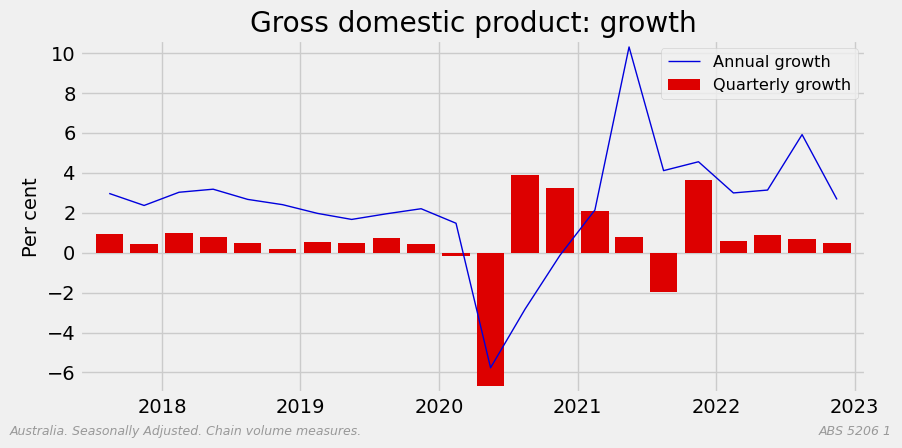

Last: [3.239348865302838, 0.24860769125090165]


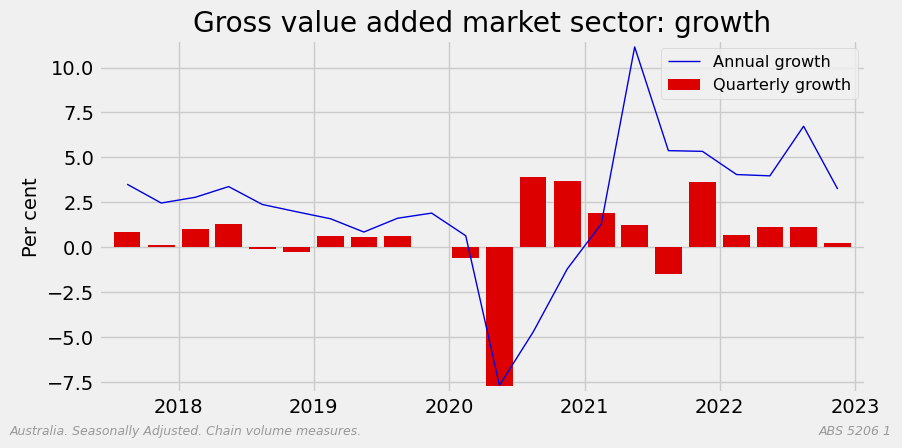

Last: [2.7209839270248226, 0.4598822422743343]


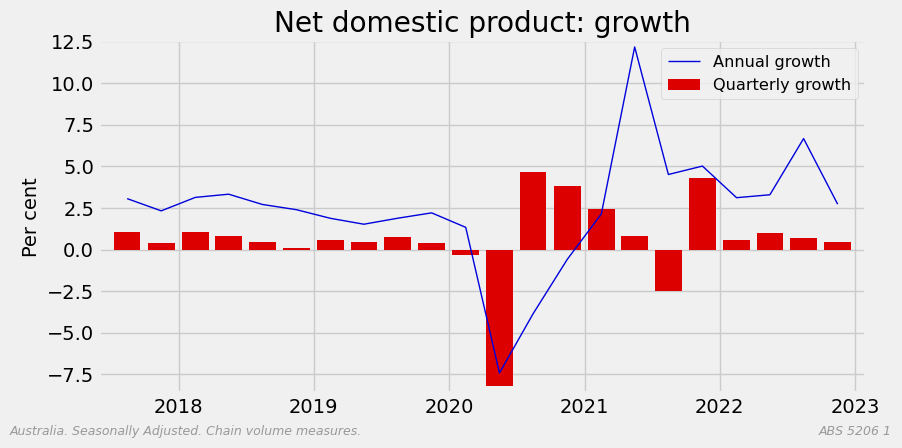

Last: [4.386601034295845, 0.6314778559058265]


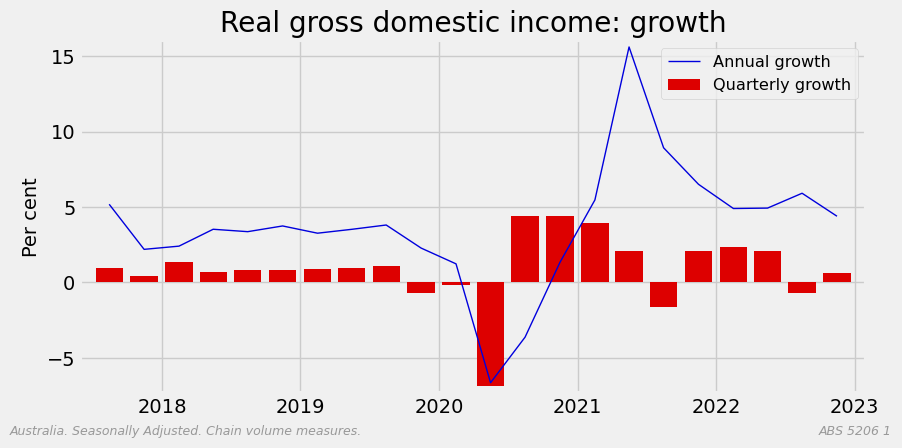

Last: [3.649902575575137, 1.4102799935338695]


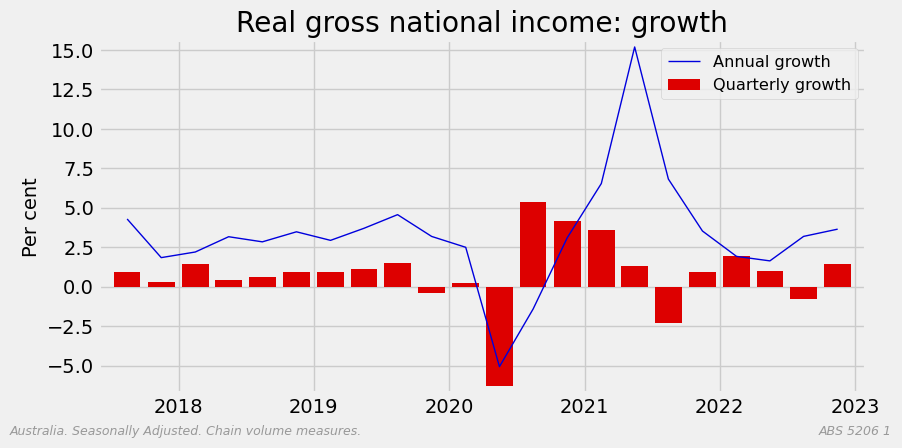

Last: [4.020956847986734, 1.570081757735009]


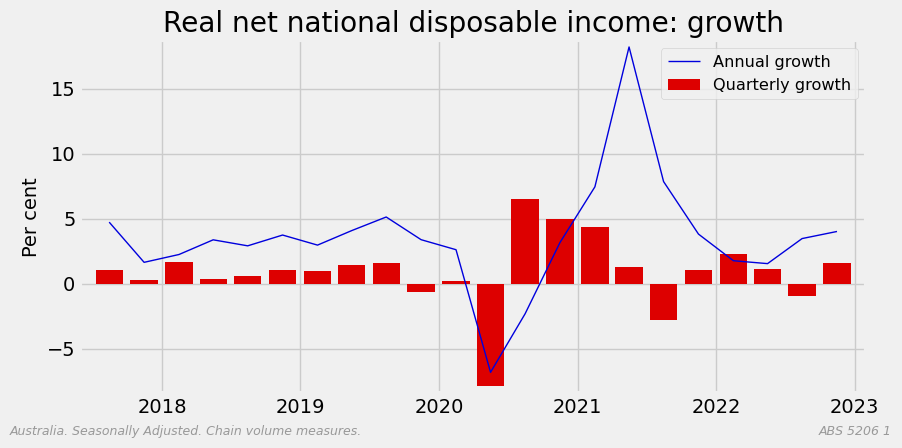

In [5]:
# identify available headline series from metadata
table = "1"
data = abs_dict[table]

series_type = "Seasonally Adjusted"
rows = meta[
    (meta[table_col] == table)
    & (meta[type_col] == series_type)
    & (meta[unit_col] == value_text)
    & (meta[did_col].str.contains(CVM))
]

for index, row in rows.iterrows():
    # identify data
    series_id, units, title = row[id_col], row[unit_col], row[did_col]
    units = units + " / Quarter"  # make this clear
    series, units = recalibrate_series(data[series_id], units)
    lfooter = f"Australia. {series_type}. "
    title, lfooter = fix_abs_title(title, lfooter)

    # plot
    for plot_from, plot_tag in zip(plot_times, plot_tags):
        plot_from = pd.Period(plot_from, freq="Q") if plot_from is not None else None

        # plot raw quarterly data
        plotable = (
            series if plot_from is None else series[series.index > plot_from]
        ).dropna()
        ax = plotable.plot(lw=2, color="#dd0000")
        finalise_plot(
            ax,
            title=title,
            ylabel=units,
            tag=plot_tag,
            rfooter=f"{source} {table}",
            lfooter=lfooter,
            # show=True,
        )

        # plot quarterly and through the year growth
        growth = calc_growth(series)
        if plot_from:
            print(f"Last: {[x[-1] for x in growth]}")
        plot_growth_finalise(
            *growth,
            from_=plot_from,
            title=f"{title} growth",
            tag=plot_tag,
            rfooter=f"{source} {table}",
            lfooter=lfooter,
            show=plot_from is not None,
        )

### Long run annual GDP Growth - using a Henderson moving average

In [6]:
def chart_gdp_long_run_growth(chart: str) -> None:
    # key data sources
    table = "1"
    data = abs_dict[table]
    series_type = "Seasonally Adjusted"

    # select series
    selector = {
        table: table_col,
        chart: did_col,
        series_type: type_col,
        CVM: did_col,
        "$": unit_col,
    }
    id, units = find_id(meta, selector, verbose=False)

    # plot original
    ax = None  # so we can comment out a plot code-line
    q_gdp = data[id].dropna()
    series = (q_gdp.pct_change(periods=4, fill_method=None) * 100).dropna()
    ax = series.plot(color="darkblue", lw=0.5, ls="-", ax=ax, label="Annual growth")

    # plot Henderson Moving Average
    HENDERSON_N = 13  # months ==> multi-year Henderson moving average
    smoothed = hma(series, HENDERSON_N)
    ax = smoothed.plot(
        color="darkorange",
        lw=1.5,
        ls="-",
        ax=ax,
        label=f"{HENDERSON_N}-term Henderson moving average",
    )

    # plot decadal averages
    decades = series.index.year.astype(str).str[2:3].unique()
    label = "Decadal mean (DM) annual growth"
    for decade in decades:
        d_series = series[series.index.year.astype(str).str[2:3] == decade]
        d_series = pd.Series(
            np.repeat(d_series.mean(), len(d_series)), index=d_series.index
        )
        ax = d_series.plot(color="darkred", lw=2, ls="--", ax=ax, label=label)
        label = None
        ax.text(
            x=d_series.index[-1],
            y=series.min(),
            s=f"DM = {d_series.iloc[-1]:0.2f}%",
            rotation=90,
            ha="center",
            size="x-small",
        )

    # plot compound annual growth rate over a decade
    YEARS = 10
    PERIODS_PER_YEAR = 4
    annual = (
        ((q_gdp / q_gdp.shift(YEARS * PERIODS_PER_YEAR)) ** (1 / YEARS)) - 1
    ) * 100
    ax = annual.plot(
        color="dodgerblue",
        lw=3,
        ls="-",
        ax=ax,
        label="Annual compound growth over decade",
    )

    # finalise the plot
    ax.legend(loc="best", prop={"size": "x-small"})
    ax.axhline(0, c="#999999", lw=0.75)
    title = f"YoY Growth - {chart} - Long-run trends"
    finalise_plot(
        ax,
        title=title,
        ylabel="Per cent / year",
        rfooter=f"{source} {table}",
        lfooter=f"Australia. {series_type.capitalize()}. "
        f"{CVM}. Compared with the same quarter in the previous year.",
        # show=True,
    )

In [7]:
charts = [
    "Gross domestic product",
    "GDP per capita",
]
for chart in charts:
    chart_gdp_long_run_growth(chart)

### Four quarter rolling totals - original series

In [8]:
table = "1"
data = abs_dict[table]
series_type = "Original"

charts = [
    "Gross domestic product",
    "GDP per capita",
]
for chart in charts:
    selector = {
        table: table_col,
        chart: did_col,
        series_type: type_col,
        CVM: did_col,
        "$": unit_col,
    }
    id, units = find_id(meta, selector, verbose=False)
    rolling4Q = data[id].rolling(4).sum()
    units = "$ Number" if units == "$" else units
    rolling4Q, units = recalibrate_series(rolling4Q, units)
    rolling4Q.name = chart

    title = meta.loc[meta[id_col] == id, did_col].iloc[0]
    lfooter = f"Australia. 4Q rolling sum. {series_type} series. "
    title, lfooter = fix_abs_title(title, lfooter)
    plot_covid_recovery(
        rolling4Q,
        title=title,
        ylabel=f"{units} / year",
        tag="-recent-covid",
        rfooter=f"{source} {table}",
        lfooter=lfooter,
        # show=True,
    )

### Quarterly - seasonally adjusted

In [9]:
table = "1"
data = abs_dict[table]
series_type = "Seasonally Adjusted"

charts = [
    "Gross domestic product",
    "GDP per capita",
]
for chart in charts:
    selector = {
        table: table_col,
        chart: did_col,
        series_type: type_col,
        CVM: did_col,
        "$": unit_col,
    }
    id, units = find_id(meta, selector, verbose=False)
    series = data[id]
    units = "$ Number" if units == "$" else units
    series, units = recalibrate_series(series, units)
    series.name = chart

    title = f"Quarterly {chart}".title().replace("Gdp", "GDP")
    plot_covid_recovery(
        series,
        title=title,
        ylabel=f"{units} / quarter",
        tag="-recent-covid",
        rfooter=f"{source} {table}",
        lfooter=f"Australia. {series_type.capitalize()} series. {CVM}. ",
        # show=True,
    )

### Implicit price deflators

In [10]:
table = "5"
data = abs_dict[table]

keys = {
    "GDP": "GROSS DOMESTIC PRODUCT ;",
    "HFCE": "Households ;  Final consumption expenditure ;",
}

gdp_deflator = None
N_HENDERSON = 17  # 4 year moving average
for prefix, key in keys.items():
    ident = meta[(meta["Data Item Description"] == key) & (meta["Table"] == table)][
        "Series ID"
    ].iloc[0]

    deflator = data[ident].dropna()
    if prefix == "GDP":
        gdp_deflator = deflator / deflator.iloc[-1]

    series1 = deflator.pct_change(4).mul(100).dropna()
    series2 = hma(
        series1,
        N_HENDERSON,
    )
    series_set = (series1, series2)
    title_tags = ("", f"({N_HENDERSON}-term Henderson MA)")

    for series, title_tag in zip(series_set, title_tags):
        ax = series.plot(lw=2, color="#dd0000")
        title = f"{prefix} Implicit Price Deflator {title_tag}"
        finalise_plot(
            ax,
            title=title,
            ylabel="Growth: Per cent per annum",
            rfooter=f"{source} {table}",
            lfooter="Calculated from the seasonally adjusted index",
            # show=True,
        )

### Savings - current prices and GDP-deflator adjusted

In [11]:
table = "11"
data = abs_dict[table]
series_type = "Seasonally Adjusted"
series_focus = "Net saving"

headline_plots = meta[
    (meta[table_col] == table)
    & (meta[type_col] == series_type)
    & (meta[did_col].str.contains(series_focus))
][did_col]

for description in headline_plots:
    # identify data
    series, units = get_identifier(meta, description, series_type, table)
    units = f"{units} / quarter"
    plotable, units = recalibrate_series(data[series].dropna(), units)

    for plot_from, plot_tag in zip(plot_times, plot_tags):
        title = description.replace(" ;", "").replace("  ", " ").capitalize()

        # plot raw quarterly data
        plot_data = plotable
        if plot_from:
            plot_data = plotable[plotable.index >= pd.Period(plot_from, freq="Q")]
        ax = plot_data.plot(lw=2, color="#dd0000")
        finalise_plot(
            ax,
            title=title,
            ylabel=units,
            tag=plot_tag,
            rfooter=f"{source} {table}",
            lfooter=f"{series_type.capitalize()} series. Current prices.",
            # show=True,
        )

        # plot price adjusted data
        plot_data = (plot_data / gdp_deflator).dropna()
        ax = plot_data.plot(lw=2, color="#dd0000")
        finalise_plot(
            ax,
            title=title,
            ylabel=f"{units} (adjusted)",
            tag=f"{plot_tag}-adjusted-prices",
            rfooter=f"{source} {table}",
            lfooter=f"{series_type.capitalize()} series. "
            "Prices adjusted using the GDP implicit price deflator. ",
            # show=True,
        )

### Gross Value Added (GVA) by Industry

In [12]:
# identify available series from metadata
table = "6"
data = abs_dict[table]

series_type = "Seasonally Adjusted"
industries = meta[
    (meta[table_col] == table)
    & (meta[type_col] == series_type)
    & (meta[unit_col] == value_text)  # limit to money
][did_col]
industry_start = pd.Period("1974-09-01", freq="Q")

for industry in industries:
    # get data
    selector = {
        table: table_col,
        series_type: type_col,
        industry: did_col,
    }

    series, units = find_id(meta, selector, exact=True, verbose=False)
    units = f"{units}  / Quarter"
    plotable, units = recalibrate_series(data[series].dropna(), units)

    # plot
    for start, tag in zip(plot_times, plot_tags):
        subset = (
            plotable[plotable.index >= pd.Period(start, freq="Q")]
            if start
            else plotable
        )
        subset = subset[subset.index >= industry_start]
        ax = subset.plot(lw=2, color="#dd0000")

        # we limit subgroup titles to keep the width
        # within what would fit on the top of a plot
        title = industry.replace(" ;", "").strip()
        if not title.endswith(")"):
            title = re.sub(r"^[^\(]+\(", "(", title)
        title = f" GVA: {title}"

        finalise_plot(
            ax,
            title=title,
            ylabel=units,
            tag=tag,
            rfooter=f"{source} {table}",
            lfooter=(f"{series_type.capitalize()}, " f"{CVM.lower()}"),
            # show=True
        )

###  Household Final Consumption Expenditure

In [13]:
# identify available series from metadata
table = "8"
data = abs_dict[table]
series_type = "Seasonally Adjusted"
hfce = meta[
    (meta["Table"] == table)
    & (meta["Series Type"] == series_type)
    & (meta["Unit"] == "$ Millions")
    & (meta["Data Item Description"].str.contains(CVM))  # limit to money
]["Data Item Description"]

for description in hfce:
    # get data
    series, units = get_identifier(meta, description, series_type, table)
    units = f"{units} / Quarter"
    plotable, units = recalibrate_series(data[series].dropna(), units)
    plotable.name = "Household consumption"
    title = description.replace(f": {CVM} ;", "")
    separator = "\n" if len(title) > 25 else " "
    title = f"Household consumption:{separator}{title}"

    # plot - complete series - and recent showing covid recoverhy
    ax = plotable.plot(lw=2, color="#dd0000")
    finalise_plot(
        ax,
        title=title,
        ylabel=units,
        rfooter=f"{source} {table}",
        lfooter=(f"{series_type.capitalize()}, " f"{CVM.lower()}"),
        # show=True
    )

    plot_covid_recovery(
        plotable,
        title=title,
        ylabel=units,
        tag="-recent-covid",
        rfooter=f"{source} {table}",
        lfooter=f"Australia. {series_type}. {CVM}. ",
        # show=True,
    )

### Taxes

In [14]:
# identify available series from metadata
table = "22"
data = abs_dict[table]
series_type = "Seasonally Adjusted"
tax_plots = meta[(meta["Table"] == table) & (meta["Series Type"] == series_type)][
    "Data Item Description"
]

for plot in tax_plots:
    # data capture
    ident, units = get_identifier(meta, plot, series_type, table)
    units = f"{units} / Quarter"
    series = data[ident]

    series, units = recalibrate_series(series, units)

    series = series[series.index >= pd.Period(RECENT, freq="Q")]
    if series.isna().all():
        # don't plot empty series
        continue

    # plot
    ax = series.plot(lw=2, color="#dd0000")
    title = plot.replace(" ;", "")
    finalise_plot(
        ax,
        title=title,
        ylabel=units,
        tag="govt-tax",
        rfooter=f"{source} {table}",
        lfooter=f"Australia. {series_type.capitalize()} series. Current Prices.",
        # show=True,
    )

### Government Benefits Payments

In [15]:
table = "23"
data = abs_dict[table]
series_type = "Original"
plots_payments = meta[(meta["Table"] == table) & (meta["Series Type"] == series_type)][
    "Data Item Description"
]

for plot in plots_payments:
    # get data
    ident, units = get_identifier(meta, plot, series_type, table)
    units = f"{units} / Qtr"
    series = data[ident].dropna()

    series, units = recalibrate_series(series, units)

    series = series[series.index >= pd.Period(RECENT, freq="Q")]
    if series.isna().all():
        # don't plot empty series
        continue

    # plot
    ax = series.plot(lw=2, color="#dd0000")

    # - from ABS description to plot title
    title = plot.replace("General government - National ;  ", "Federal Govt - ")
    title = title.replace(
        "General government - State and local ;  ", "State or Local Govt - "
    )
    title = title.replace("General government ;  ", "All Govt - ")
    title = title.replace(" ;", "")

    finalise_plot(
        ax,
        title=title,
        ylabel=f"{units} (Current Prices)",
        tag="govt-spending",
        rfooter=f"{source} {table}",
        lfooter=f"{series_type.capitalize()} series",
        # show=True,
    )

### Wages v Profit

In [16]:
wages_table = "7"
series_type = "Seasonally Adjusted"  # 'Original'
wages_id, wage_units = find_id(
    meta,
    {
        wages_table: table_col,
        series_type: type_col,
        "Compensation of employees ;": did_col,
    },
    exact=True,
    verbose=False,
)
wages = abs_dict[wages_table][wages_id]

income_table = "7"
tf_income_id, tf_income_units = find_id(
    meta,
    {
        income_table: table_col,
        series_type: type_col,
        "Total factor income ;": did_col,
    },
    exact=True,
    verbose=False,
)
tf_income = abs_dict[income_table][tf_income_id]

assert wage_units == tf_income_units

profit_share_table = "24"
profit_ratio_id, share_units = find_id(
    meta,
    {
        profit_share_table: table_col,
        "Seasonally Adjusted": type_col,
        "Profits share of total factor income: Ratio ;": did_col,
    },
    exact=True,
    verbose=False,
)
profit_tfi_share = abs_dict[profit_share_table][profit_ratio_id] / 100
profits = profit_tfi_share * tf_income

# plot shares
assert wage_units == tf_income_units
profit_wage_share = profits / (profits + wages) * 100
ax = profit_wage_share.plot(lw=1, color="darkblue", label="Profit share")
hma_term = 7
hma(profit_wage_share, hma_term).plot(
    lw=3, color="darkorange", ax=ax, label="Henderson moving average"
)
ax.legend(loc="best", fontsize="x-small")
finalise_plot(
    ax,
    title="Profits as a share of profits plus wages",
    ylabel="Per cent",
    rfooter=f"{source} Tables: {wages_table}, {profit_share_table}",
    lfooter=f"Australia. {series_type.capitalize()} series. "
    f"{hma_term}-term Henderson moving average. ",
    # show=True,
)

# plot values
assert "Millions" in wage_units
ax = (wages / 1000).plot(lw=2, color="darkblue", label=f"Wages")
(profits / 1000).plot(lw=2, color="darkorange", label=f"Profits", ax=ax)
ax.legend(loc="best", fontsize="x-small")
finalise_plot(
    ax,
    title="Profits vs Wages",
    ylabel="$ Billions",
    rfooter=f"{source} Tables: {wages_table}, {profit_share_table}",
    lfooter=f"Australia. {series_type.capitalize()} series. Current Prices. ",
    # show=True,
)

# plot index
assert wages.index[0] == profits.index[0]
ax = (wages / wages.iloc[0]).plot(lw=2, color="darkblue", label=f"Wages")
(profits / profits.iloc[0]).plot(lw=2, color="darkorange", label=f"Profits", ax=ax)
ax.legend(loc="best", fontsize="x-small")
finalise_plot(
    ax,
    title="Profits index vs Wages index",
    ylabel=f"Index ({wages.index[0]} = 1)",
    rfooter=f"{source} Tables: {wages_table}, {profit_share_table}",
    lfooter=f"Australia. {series_type.capitalize()} series. Current Prices. ",
    # show=True,
)

## Finished

In [17]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Sun Mar 05 2023 15:17:25

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.11.0

re        : 2.2.1
sys       : 3.11.0 | packaged by conda-forge | (main, Jan 15 2023, 05:44:48) [Clang 14.0.6 ]
matplotlib: 3.7.0
numpy     : 1.24.2
pandas    : 1.5.3

Watermark: 2.3.1



In [18]:
print("Finished")

Finished
